# QBUS3850 Tutorial 9: ARCH/GARCH Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from arch import arch_model

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

## Import Data

Import Data for "BHP00-20.csv", containing daily prices for BHP stock between 2000-01-04 and 2020-04-06.

In [2]:
data = pd.read_csv('BHP00-20.csv', index_col='Date', parse_dates=['Date'], dayfirst = True)
print( data.tail() )

BHPprices = data['Adj Close']

## Calculate log-returns. Drop first null observation
BHPr = ( 100 * ( np.log( BHPprices ) - np.log( BHPprices.shift() ) ) ).dropna()

                 Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2020-04-27  30.379999  30.629999  30.020000  30.500000  30.500000   4599305.0
2020-04-28  30.389999  30.924999  30.305000  30.490000  30.490000   6669047.0
2020-04-29  30.950001  31.150000  30.610001  31.120001  31.120001   5057865.0
2020-04-30  32.000000  32.430000  31.549999  32.349998  32.349998  11011723.0
2020-05-01  31.250000  31.309999  30.680000  30.820000  30.820000   1895017.0


In [3]:
## Plot diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()
    

In [4]:
## Statistical diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## Ljung-Box tests on squared standardised residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## ARCH test on mean-corrected returns
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()


### Q1(a) Fit a constant mean ARCH model to the log-returns, with lag order p chosen by AIC and/or SIC. What is the fitted model? Are all chosen ARCH lags significant?

In [5]:
ps = range( 1, 21 )
LLF = []
aic = []
sic = []
for p in ps:
    ## Estimate model (disp = 'off' to suppress output)
    EstMdl = arch_model(y = BHPr, mean = 'Constant', vol = 'ARCH', p = p).fit( disp= 'off' )
    LLF.append( EstMdl.loglikelihood )
    aic.append( -2 * EstMdl.loglikelihood + 2*p )
    sic.append( -2 * EstMdl.loglikelihood + np.log( len( BHPr ) ) * p )


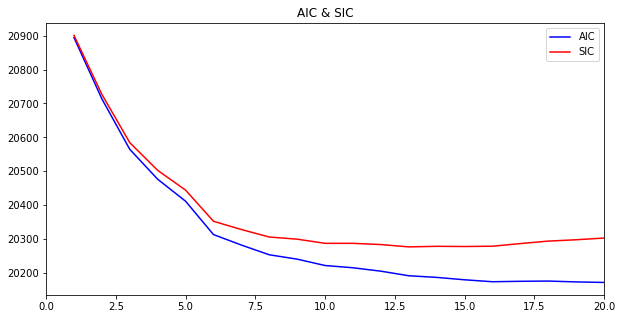

In [6]:
fig = plt.figure()
plt.plot( ps, aic, color = 'blue', label = 'AIC' )
plt.plot( ps, sic, color = 'red', label = 'SIC' )
plt.xlim( 0, 20 )
plt.legend()
plt.title( 'AIC & SIC' )
plt.show()

#AIC choses p=20
#SIC chooses p=15. 


                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -10074.7
Distribution:                  Normal   AIC:                           20183.5
Method:            Maximum Likelihood   BIC:                           20294.9
                                        No. Observations:                 5173
Date:                Fri, May 01 2020   Df Residuals:                     5156
Time:                        10:43:36   Df Model:                           17
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0680  2.158e-02      3.150  1.634e-03 [2.568e-0

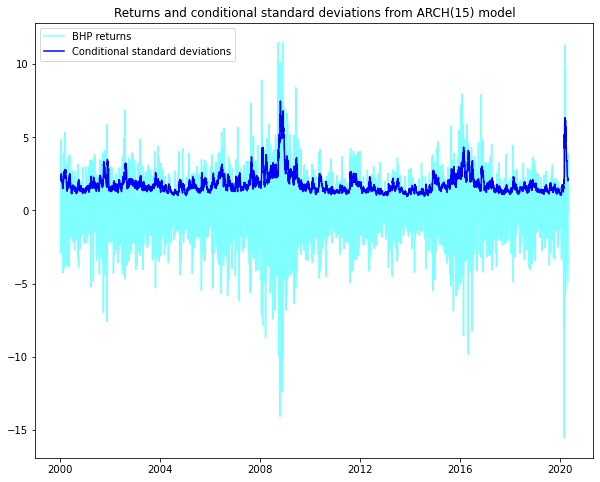

In [7]:
## Estimate ARCH(15) model
EstMdl = arch_model( BHPr, mean='Constant', vol='ARCH', p = 15).fit( disp = 'off' )
print( EstMdl.summary() )
coef_15 = EstMdl.params[2:]

## Infer the conditional standard deviations and variance.
s_15 = EstMdl.conditional_volatility
v_15 = s_15**2
a_15 = BHPr - EstMdl.params['mu']
e_15 = a_15 / s_15

#Plot Returns and conditional standard deviations
fig = plt.figure(figsize= (10,8))
plt.plot( BHPr, color = 'cyan', alpha = 0.5, label = 'BHP returns' )
plt.plot( s_15, color = 'blue', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from ARCH(15) model' )
plt.legend()
plt.show()

### Q1(b) Assess the fit of the model in (a) using ACF plots, Ljung-Box and ARCH tests, and a histogram/qqplot together with the Jarque-Bera test.

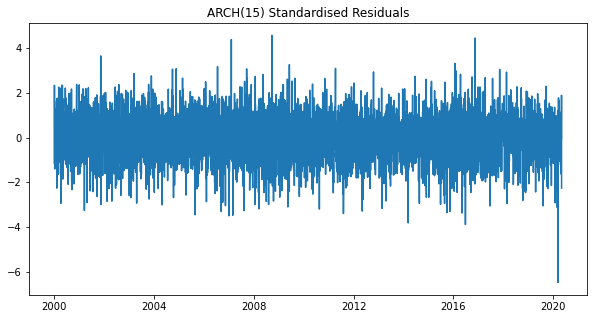

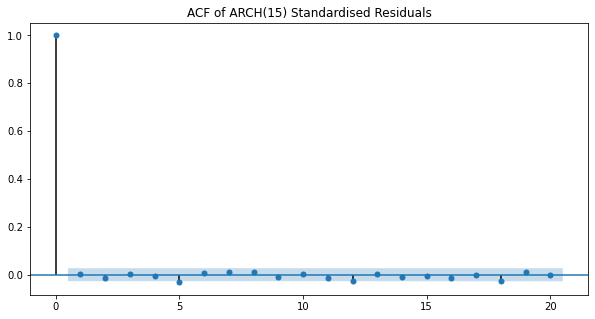

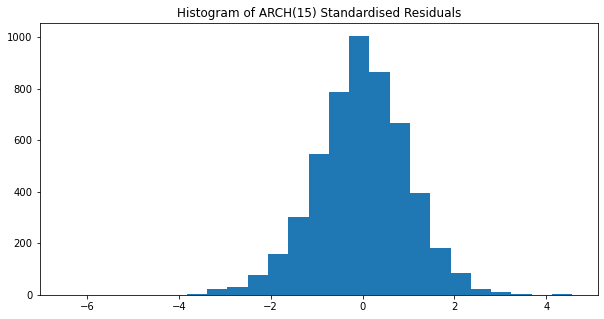

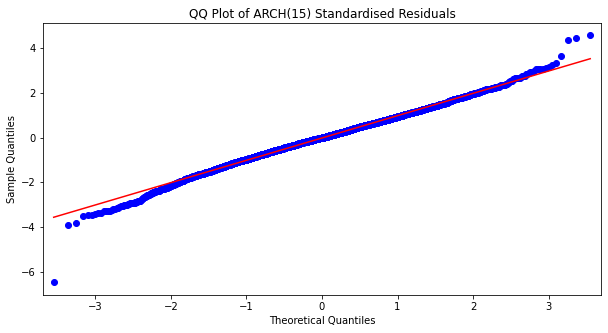

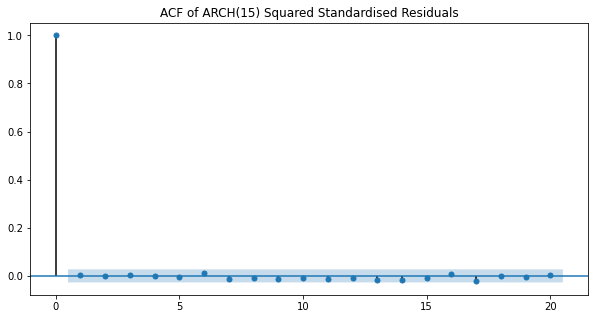

In [8]:
assess_fit_plots( e_15, 'ARCH(15)' )

In [9]:
assess_fit_stats( e_15, 15 )   

Ljung-Box Q-statistic on standardised residuals:
maxlag: 20. Q-stat: 19.447354. P-value: 0.001586
maxlag: 25. Q-stat: 20.196555. P-value: 0.027447

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 20. Q-stat: 10.861323. P-value: 0.054200
maxlag: 25. Q-stat: 13.457642. P-value: 0.199198

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 0.244753. P-value: 0.998555
maxlag: 10. ARCH test statistic: 3.319420. P-value: 0.972877

Skewness: -0.166747
Kurtosis: 3.881490
JB test statistic: 191.453148. P-value 0.000000



### Q1(c) Fit an ARCH(p) model to the log-return series using Student-t errors and estimate the degrees of freedom. Compare parameter estimates to those in Q1(a).

In [10]:
ps = range( 1, 21 )
LLF = []
aic = []
sic = []
for p in ps:
    ## Estimate model (disp = 'off' to suppress output)
    Mdl = arch_model(y = BHPr, mean = 'Constant', vol = 'ARCH', p = p, dist = 'studentst')
    EstMdl = Mdl.fit( disp= 'off' )
    LLF.append( EstMdl.loglikelihood )
    aic.append( -2 * EstMdl.loglikelihood + 2*p )
    sic.append( -2 * EstMdl.loglikelihood + np.log( len( BHPr ) ) * p )


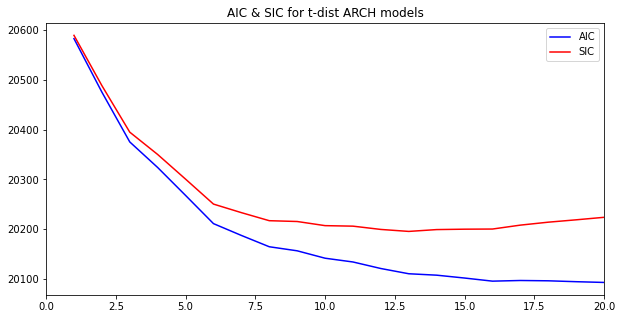

In [11]:
fig = plt.figure()
plt.plot( ps, aic, color = 'blue', label = 'AIC' )
plt.plot( ps, sic, color = 'red', label = 'SIC' )
plt.xlim( 0, 20 )
plt.legend()
plt.title( 'AIC & SIC for t-dist ARCH models' )
plt.show()
#AIC choses p=20, SIC chooses p=13. 

In [12]:
## Fit ARCH(13)-t Model
## nu = Student's t dist degrees of freedom.
EstMdl = arch_model( BHPr, mean='Constant', vol='ARCH', p = 13, dist = 'studentst').fit( disp = 'off' )
print( EstMdl.summary() )
coef_13t = EstMdl.params[2:-1]

s_13t = EstMdl.conditional_volatility #infer the conditional standard deviations
v_13t = s_13t**2 #Conditional variance
a_13t = BHPr - EstMdl.params['mu'] #Calculate innovations
e_13t = a_13t / s_13t

#Tranform t-errors to normal errors
dft = EstMdl.params['nu']
n_13t = stats.norm.ppf( stats.t.cdf( np.sqrt( dft ) / np.sqrt( dft - 2 ) * e_13t, df = dft ) )


                         Constant Mean - ARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             ARCH   Log-Likelihood:               -10042.1
Distribution:      Standardized Student's t   AIC:                           20116.3
Method:                  Maximum Likelihood   BIC:                           20221.1
                                              No. Observations:                 5173
Date:                      Fri, May 01 2020   Df Residuals:                     5157
Time:                              10:43:59   Df Model:                           16
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

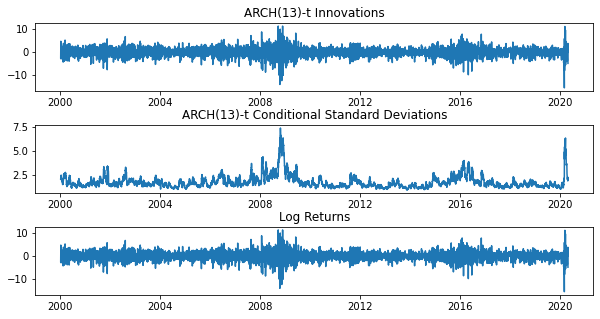

In [13]:
fig,axs = plt.subplots( 3, 1 )
axs[0].plot( a_13t )
axs[0].set_title( 'ARCH(13)-t Innovations' )

axs[1].plot( s_13t )
axs[1].set_title( 'ARCH(13)-t Conditional Standard Deviations' )

axs[2].plot( BHPr )
axs[2].set_title( 'Log Returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()

### Q1(d) Does the Student-t error model fit better than the Gaussian error model? Does it make a substantially different volatility process?

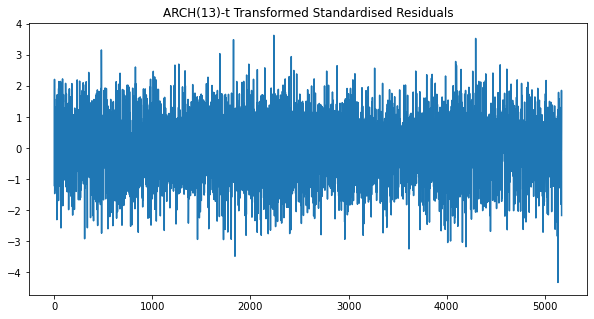

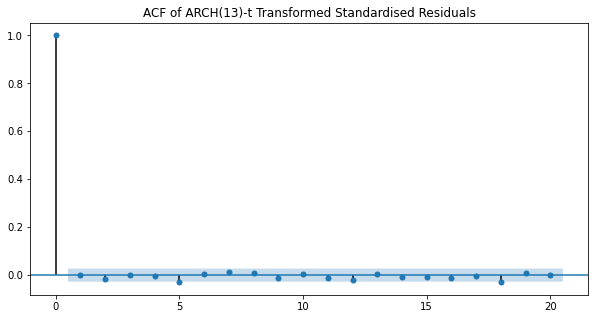

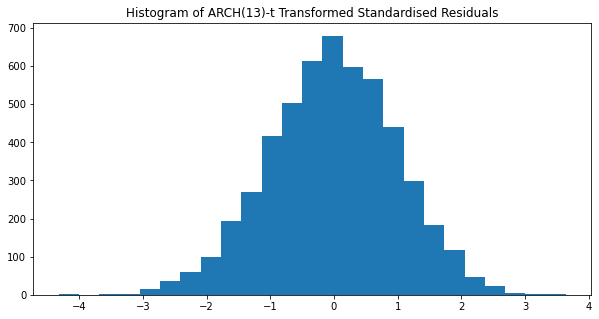

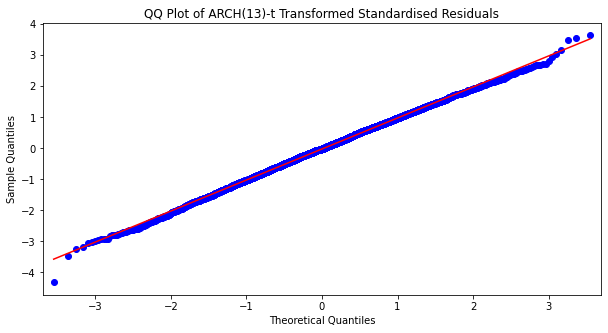

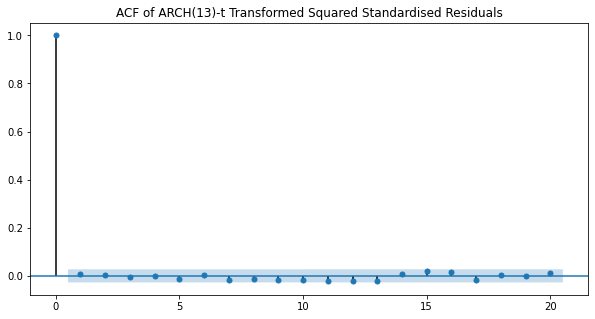

In [14]:
assess_fit_plots( n_13t, 'ARCH(13)-t Transformed' )

In [15]:
assess_fit_stats( n_13t, 14 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 19. Q-stat: 17.485835. P-value: 0.003665
maxlag: 24. Q-stat: 17.813472. P-value: 0.058193

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 19. Q-stat: 17.540173. P-value: 0.003581
maxlag: 24. Q-stat: 21.411929. P-value: 0.018397

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 1.277725. P-value: 0.937207
maxlag: 10. ARCH test statistic: 6.504786. P-value: 0.771222

Skewness: -0.103100
Kurtosis: 2.996168
JB test statistic: 9.167711. P-value 0.010215



### Q2(a) Fit a Gaussian-error AR(1)-GARCH(1,1) model to the log-return series. Did you find a significant AR effect? Compare the estimated volatility series to those in Q1(a).

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -10059.9
Distribution:                  Normal   AIC:                           20129.9
Method:            Maximum Likelihood   BIC:                           20162.7
                                        No. Observations:                 5172
Date:                Fri, May 01 2020   Df Residuals:                     5167
Time:                        10:44:02   Df Model:                            5
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0632  2.146e-02      2.946

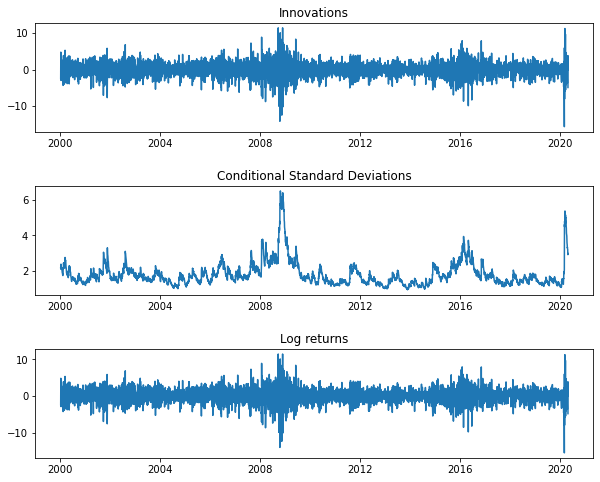

In [16]:
## Estimate AR(1)-GARCH(1,1) model
## ARX specifies the use of an autoregressive mean model
## The results show no significant AR effect.
EstMdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1).fit(disp = 'off')
print( EstMdl.summary() )

LLF = EstMdl.loglikelihood
s = EstMdl.conditional_volatility #infer the conditional standard deviations
v = s**2 #Conditional variance
a = BHPr - EstMdl.params['Const'] #Calculate innovations
e = ( a / s )[1:]

#Plot the innovations, conditional standard deviations and log returns above one another
fig, axs = plt.subplots(3,1, figsize = (10,8))
axs[0].plot( a )
axs[0].set_title( 'Innovations' )

axs[1].plot( s )
axs[1].set_title( 'Conditional Standard Deviations' )

axs[2].plot( BHPr )
axs[2].set_title( 'Log returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()


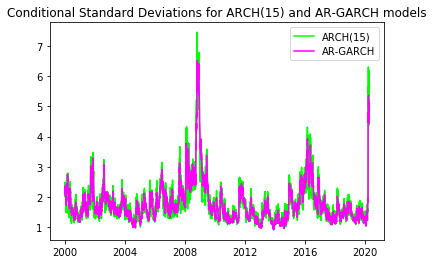

In [17]:
#Plot conditional standard deviations for ARCH(15) and GARCH model for comparison
plt.plot( s_15, color = 'lime', label = 'ARCH(15)')
plt.plot( s, color = 'magenta', label = 'AR-GARCH')
plt.title( 'Conditional Standard Deviations for ARCH(15) and AR-GARCH models' )
plt.legend()
plt.show()


### Q2(b) Assess the fit of the AR(1)-GARCH(1,1) model

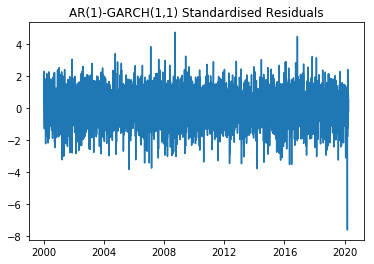

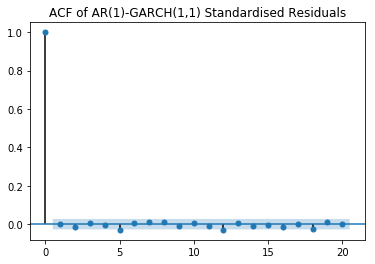

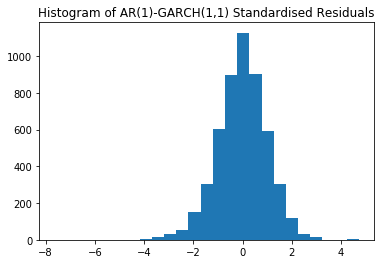

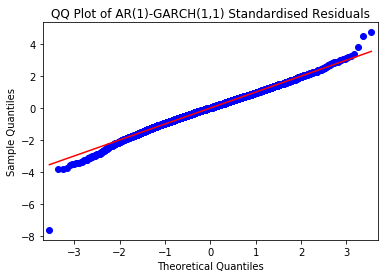

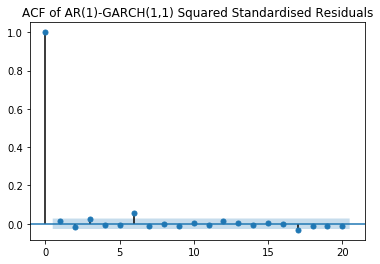

In [18]:
assess_fit_plots( e, 'AR(1)-GARCH(1,1)' )

In [19]:
assess_fit_stats( e, 3 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 8. Q-stat: 7.343811. P-value: 0.196300
maxlag: 13. Q-stat: 13.396229. P-value: 0.202354

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 8. Q-stat: 23.730735. P-value: 0.000245
maxlag: 13. Q-stat: 25.863578. P-value: 0.003928

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 6.296020. P-value: 0.278471
maxlag: 10. ARCH test statistic: 25.159108. P-value: 0.005052

Skewness: -0.222156
Kurtosis: 4.160004
JB test statistic: 331.428379. P-value 0.000000



### Q2(c) Re-fit an AR(1)-GARCH(1,1) model using Student-t errors

In [20]:
## Estimate AR(1)-GARCH(1,1) model
## ARX specifies the use of an autoregressive mean model
Mdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
EstMdl = Mdl.fit( disp = 'off' )
print( EstMdl.summary() )

LLF = EstMdl.loglikelihood
st = EstMdl.conditional_volatility #infer the conditional standard deviations
vt = st**2 #Conditional variance
at = BHPr - EstMdl.params['Const'] #Calculate innovations


                              AR - GARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -9974.18
Distribution:      Standardized Student's t   AIC:                           19960.4
Method:                  Maximum Likelihood   BIC:                           19999.6
                                              No. Observations:                 5155
Date:                      Mon, Apr 27 2020   Df Residuals:                     5149
Time:                              11:23:35   Df Model:                            6
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

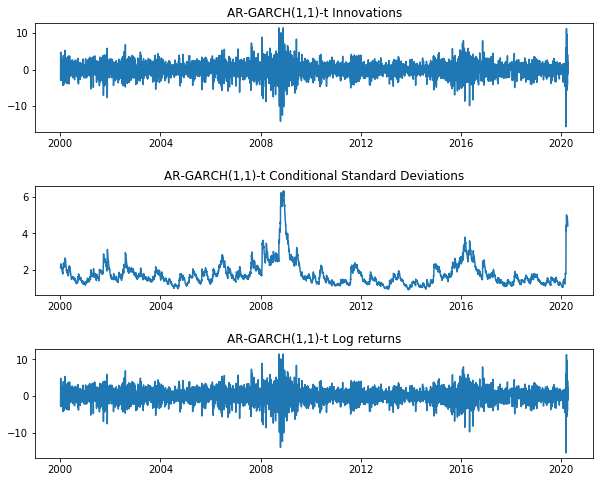

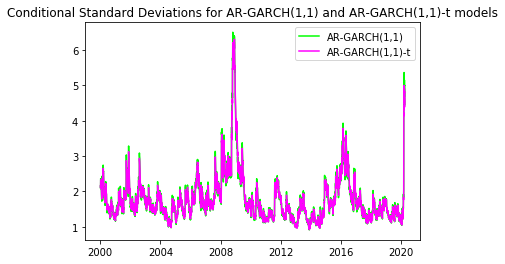

In [21]:
#Plot the innovations, conditional standard deviations and log returns above one another
fig, axs = plt.subplots(3,1, figsize = (10,8))
axs[0].plot( at )
axs[0].set_title( 'AR-GARCH(1,1)-t Innovations' )

axs[1].plot( st )
axs[1].set_title('AR-GARCH(1,1)-t Conditional Standard Deviations' )

axs[2].plot( BHPr )
axs[2].set_title( 'AR-GARCH(1,1)-t Log returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()

#Plot conditional standard deviations for ARCH(15) and GARCH model for comparison
plt.plot( s, color = 'lime', label = 'AR-GARCH(1,1)')
plt.plot( st, color = 'magenta', label = 'AR-GARCH(1,1)-t')
plt.title( 'Conditional Standard Deviations for AR-GARCH(1,1) and AR-GARCH(1,1)-t models' )
plt.legend()
plt.show()


### Q2(d) Assess fit of AR-GARCH(1,1)-t model

In [22]:
#Tranform t-errors to normal errors
dft = EstMdl.params['nu']
et = at[1:]/st[1:]
nt = stats.norm.ppf( stats.t.cdf( np.sqrt( dft ) / np.sqrt( dft - 2) * et, df = dft ) )

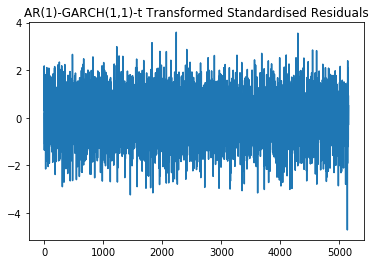

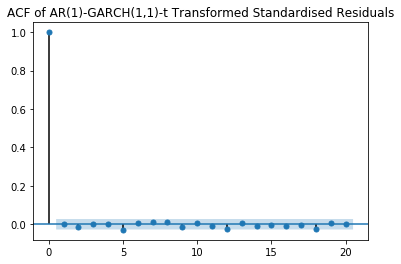

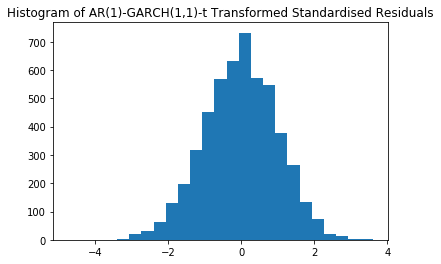

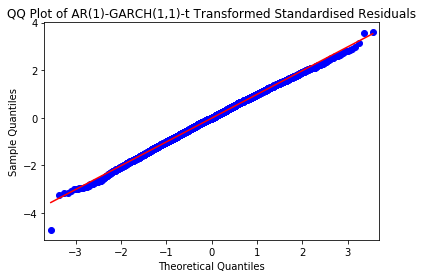

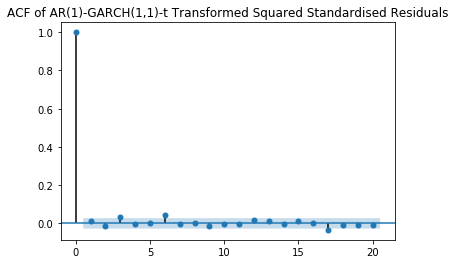

In [23]:
assess_fit_plots( nt, 'AR(1)-GARCH(1,1)-t Transformed' )

In [24]:
assess_fit_stats( nt, 4 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 9. Q-stat: 8.508666. P-value: 0.130341
maxlag: 14. Q-stat: 13.082328. P-value: 0.219105

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 9. Q-stat: 18.341728. P-value: 0.002547
maxlag: 14. Q-stat: 20.870356. P-value: 0.022016

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 8.267555. P-value: 0.142094
maxlag: 10. ARCH test statistic: 18.763213. P-value: 0.043375

Skewness: -0.122693
Kurtosis: 3.004445
JB test statistic: 12.937868. P-value 0.001551



### Q2(e) Use AIC, SIC to choose suitable GARCH model order. Fit this model and assess its fit to the data.

In [33]:
## Consider AR(1)-GARCH(p,q) models with gaussian and student t errors
aic_AR = np.zeros( ( 4, 4 ) )
sic_AR = np.zeros( ( 4, 4 ) )

aic_AR_t = np.zeros( ( 4, 4 ) )
sic_AR_t = np.zeros( ( 4, 4 ) )

## Consider GARCH(p,q) models with gaussian and student t errors i.e. no AR term
aic = np.zeros( ( 4, 4 ) )
sic = np.zeros( ( 4, 4 ) )

aic_t = np.zeros( ( 4, 4 ) )
sic_t = np.zeros( ( 4, 4 ) )


for p in range( 1, 4 ):
    for q in range( 1, 4 ):
        Mdl_AR = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'gaussian')
        EstMdl_AR = Mdl_AR.fit(disp='off')
        aic_AR[p,q] = -2 * EstMdl_AR.loglikelihood + 2 * ( p + q + 1 )
        sic_AR[p,q] = -2 * EstMdl_AR.loglikelihood + np.log( len( BHPr ) ) * ( p + q + 1 )
        
        Mdl_AR_t = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'studentst')
        EstMdl_AR_t = Mdl_AR_t.fit(disp='off')
        aic_AR_t[p,q] = -2 * EstMdl_AR_t.loglikelihood + 2 * ( p + q + 2 ) 
        sic_AR_t[p,q] = -2 * EstMdl_AR_t.loglikelihood + np.log( len( BHPr ) ) * ( p + q + 2 )

        Mdl = arch_model( BHPr, mean = 'Constant', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'gaussian')
        EstMdl = Mdl.fit(disp='off')
        aic[p,q] = -2 * EstMdl_AR.loglikelihood + 2 * ( p + q )
        sic[p,q] = -2 * EstMdl_AR.loglikelihood + np.log( len( BHPr ) ) * ( p + q )

        Mdl_t = arch_model( BHPr, mean = 'Constant', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'studentst')
        EstMdl_t = Mdl_t.fit(disp='off')
        aic_t[p,q] = -2 * EstMdl_AR_t.loglikelihood + 2 * ( p + q + 1 ) 
        sic_t[p,q] = -2 * EstMdl_AR_t.loglikelihood + np.log( len( BHPr ) ) * ( p + q + 1 )



In [34]:
print( aic_AR )
print( aic_AR_t)
print( aic )
print( aic_t )
print()

print( sic_AR )
print( sic_AR_t)
print( sic )
print( sic_t )

[[    0.             0.             0.             0.        ]
 [    0.         20042.46244541 20039.00482566 20040.96142328]
 [    0.         20044.46244538 20041.00482548 20041.94851125]
 [    0.         20046.41359002 20042.38826866 20039.6911243 ]]
[[    0.             0.             0.             0.        ]
 [    0.         19956.35309137 19955.89674352 19957.89674355]
 [    0.         19958.35309127 19957.66282121 19959.66282127]
 [    0.         19959.71164144 19957.56756147 19956.84046714]]
[[    0.             0.             0.             0.        ]
 [    0.         20040.46244541 20037.00482566 20038.96142328]
 [    0.         20042.46244538 20039.00482548 20039.94851125]
 [    0.         20044.41359002 20040.38826866 20037.6911243 ]]
[[    0.             0.             0.             0.        ]
 [    0.         19954.35309137 19953.89674352 19955.89674355]
 [    0.         19956.35309127 19955.66282121 19957.66282127]
 [    0.         19957.71164144 19955.56756147 19954

In [35]:
## SIC chooses a constant mean GARCH(1,1) with t-errors.
#Estimate chosen model 
Mdl = arch_model( BHPr, mean = 'Constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
EstMdl = Mdl.fit(disp='off') #Estimate model, use disp = 'off' to suppress estimation output
print( EstMdl.summary() )

st = EstMdl.conditional_volatility #infer the conditional standard deviations
vt = st**2 #Conditional variance
at = BHPr - EstMdl.params['mu'] #Calculate innovations

#Tranform t-errors to normal errors
dft = EstMdl.params['nu']
et = at[1:]/st[1:]
nt = stats.norm.ppf( stats.t.cdf( np.sqrt( dft ) / np.sqrt( dft - 2 ) * et, df = dft ) )


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -9976.89
Distribution:      Standardized Student's t   AIC:                           19963.8
Method:                  Maximum Likelihood   BIC:                           19996.5
                                              No. Observations:                 5156
Date:                      Mon, Apr 27 2020   Df Residuals:                     5151
Time:                              11:32:43   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

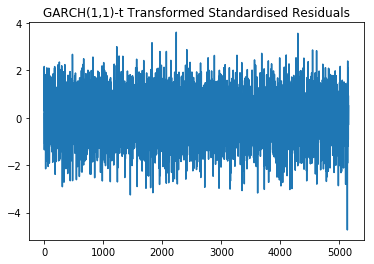

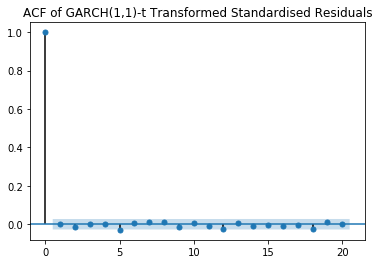

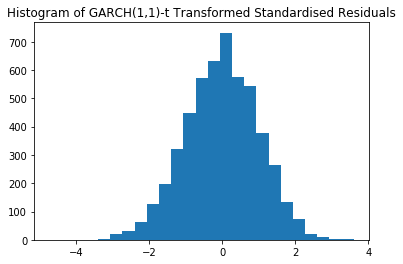

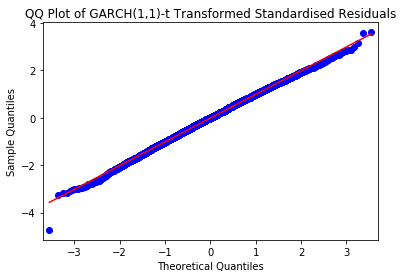

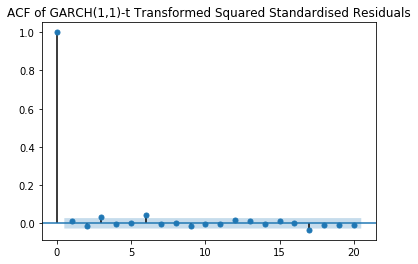

In [59]:
assess_fit_plots( nt, 'GARCH(1,1)-t Transformed' )

In [60]:
assess_fit_stats( nt, 4 )

Ljung-Box Q-statistic on standardised residuals:
maxlag: 9. Q-stat: 8.561253. P-value: 0.127897
maxlag: 14. Q-stat: 13.144615. P-value: 0.215698

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 9. Q-stat: 18.159641. P-value: 0.002753
maxlag: 14. Q-stat: 20.638571. P-value: 0.023760

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 8.193754. P-value: 0.145876
maxlag: 10. ARCH test statistic: 18.580797. P-value: 0.045922

Skewness: -0.123183
Kurtosis: 3.009047
JB test statistic: 13.054538. P-value 0.001463



### Q2(f) Which model, of all those above, is 'best' for this dataset? Give evidence and a discussion.

In [36]:
## SIC favours GARCH(1,1)-t.

### Q2(g) Find 1-step ahead predictions of VaR and ES at $\alpha = 0.05, 0.01$ under the models in a), d) and f). Which risk level forecasts do you think would be more accurate and/or believable?

In [61]:
def VaR_normal( p ):
    return stats.norm.ppf( p )
        
def ES_normal( p ):
    return -stats.norm.pdf( stats.norm.ppf( p ) ) / p

def VaR_studentst( p, df ):
    return stats.t.ppf( p, df ) * np.sqrt( ( df - 2 ) / df )

def ES_studentst( p, df ):
    return -stats.t.pdf( stats.t.ppf( p, df ), df ) / p * ( df + stats.t.ppf( p, df )**2 ) / ( df - 1 ) * np.sqrt( ( df - 2 ) / df )


In [62]:
def fcast_var_es_g( model, name ):
    EstMdl = model.fit(disp='off') #Estimate model, use disp = 'off' to suppress estimation output
    #print(EstMdl.summary())
    
    s = EstMdl.conditional_volatility #infer the conditional standard deviations
    v = s**2 #Conditional variance
    
    forecast = EstMdl.forecast(horizon=1, start = 1) #Compute 1 step ahead forecast
    v_forecast = forecast.variance.values[-1] #Save the final 1 step ahead forecast
    m_forecast = forecast.mean.values[-1]
    s_forecast = np.sqrt(v_forecast)

    for p in [ 0.05, 0.01 ]:
        VaR = m_forecast + s_forecast * VaR_normal( p )
        print('{0} VAR {1}%:{2}'.format( name, p*100, VaR))
        ES = m_forecast + s_forecast * ES_normal( p )
        print('{0} ES {1}%:{2}'.format( name, p*100, ES))
    
    
def fcast_var_es_t( model, name ):
    EstMdl = model.fit( disp = 'off' )
    #print( EstMdl.summary() )

    s = EstMdl.conditional_volatility #infer the conditional standard deviations
    v = s**2 #Conditional variance
    df = EstMdl.params['nu']

    forecast = EstMdl.forecast(horizon = 1, start = 1) #Compute 1 step ahead forecast
    v_forecast = forecast.variance.values[-1] #Save the final 1 step ahead forecast
    m_forecast = forecast.mean.values[-1]
    s_forecast = np.sqrt(v_forecast)

    for p in [ 0.05, 0.01 ]:
        VaR = m_forecast + s_forecast * VaR_studentst( p , df )
        print('{0} VAR {1}%:{2}'.format( name, p*100, VaR ) )
        ES = m_forecast + s_forecast * ES_studentst( p, df )
        print('{0} ES {1}%:{2}'.format( name, p*100, ES ) )

        
## a) AR(1)-GARCH(1,1)-G    
Mdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1)
fcast_var_es_g( Mdl, 'AR(1)-GARCH(1,1)-N' )

## d) AR(1)-GARCH(1,1)-t
Mdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
fcast_var_es_t( Mdl, 'AR(1)-GARCH(1,1)-t' )

## f) GARCH(1,1)-t
Mdl = arch_model( BHPr, mean = 'Constant', lags = 1, vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
fcast_var_es_t( Mdl, 'GARCH(1,1)-t' )


AR(1)-GARCH(1,1)-N VAR 5.0%:[-7.04691946]
AR(1)-GARCH(1,1)-N ES 5.0%:[-8.85143892]
AR(1)-GARCH(1,1)-N VAR 1.0%:[-9.98994354]
AR(1)-GARCH(1,1)-N ES 1.0%:[-11.45333348]
AR(1)-GARCH(1,1)-t VAR 5.0%:[-6.93460465]
AR(1)-GARCH(1,1)-t ES 5.0%:[-9.16715605]
AR(1)-GARCH(1,1)-t VAR 1.0%:[-10.50835161]
AR(1)-GARCH(1,1)-t ES 1.0%:[-12.70473568]
GARCH(1,1)-t VAR 5.0%:[-6.93499089]
GARCH(1,1)-t ES 5.0%:[-9.17133201]
GARCH(1,1)-t VAR 1.0%:[-10.51541304]
GARCH(1,1)-t ES 1.0%:[-12.71243944]


In [63]:
## For comparison
print( np.quantile( BHPr, 0.05 ) )
print( np.mean( BHPr[ BHPr < np.quantile(BHPr, 0.05 ) ] ) )

-3.0032403520114492
-4.383109091912978
